In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib

from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

In [2]:
test_data = pd.read_csv('../data/test_transformed.csv')
train_data = pd.read_csv('../data/train_transformed.csv')
submission_sample = pd.read_csv('../data/sample_submission.csv')

In [3]:
train_data['Transported'] = train_data['Transported'].replace({True: 1, False: 0})
train_data['VIP'] = train_data['VIP'].replace({True: 'True', False: 'False'})
train_data['CryoSleep'] = train_data['CryoSleep'].replace({True: 'True', False: 'False'})
test_data['VIP'] = test_data['VIP'].replace({True: 'True', False: 'False'})
test_data['CryoSleep'] = test_data['CryoSleep'].replace({True: 'True', False: 'False'})

In [4]:
train_target = train_data['Transported']
train_features = train_data.drop(['Name', 'PassengerId', 'Transported'], axis=1)
test_features = test_data.drop(['Name', 'PassengerId'], axis=1)

In [5]:
cat_feat = train_features.select_dtypes(np.object)
num_feat = train_features.select_dtypes(np.number)

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(train_features, train_target, test_size=0.3, random_state=42)

In [7]:
cat_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder())
    ])

num_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', Normalizer())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', cat_pipe, cat_feat.columns),
        ('scaler', num_pipe, num_feat.columns)
    ])

In [8]:
test_scores = [] 

for i in np.arange(1,46): # 46 is the number of features after encoding and scaling. 
                          # this is a for loop to find the best k value for SelectKbest
    clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=chi2, k=i+1)),
        ('classifier', XGBClassifier())
    ])
    
    clf.fit(X_train, y_train)
    test_scores.append(clf.score(X_validation, y_validation))

best_k_value = test_scores.index(max(test_scores))+1

print('best k value =', best_k_value)
print('classification score =', max(test_scores))

best k value = 27
classification score = 0.7940950920245399


In [9]:
clf = Pipeline(
    steps=[
       ('preprocessor', preprocessor),
       ('selector', SelectKBest(score_func=chi2, k=best_k_value)),
       ('classifier', XGBClassifier())
    ])

In [10]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'PassengerNumber',
       'GroupSize', 'CabinDeck', 'CabinSide', 'GroupNumberBuckets',
       'CabinNumberBuckets'],
      dtype='object')),
                                                 ('scaler',
                                                  P...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [11]:
clf.predict(X_validation)

array([0, 1, 1, ..., 0, 1, 1])

In [12]:
print('train score =',clf.score(X_train, y_train))
print('test score =', clf.score(X_validation, y_validation))

train score = 0.9153656532456861
test score = 0.7910276073619632


In [13]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__max_depth': [4, 6, 8],
    'classifier__subsample': [0.5, 0.7, 0.9]
}

grid = GridSearchCV(clf, param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'PassengerNumber',
       'GroupSize', 'CabinDeck', 'CabinSide', 'GroupNumberBuckets',
       'CabinNumberBuckets'],...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3],
                         'classifier__max_depth': [4, 6, 8],
                         'classifier__n_estimators': [50, 100],
                         'classifier__subsample': [0.5, 0.7, 0.9]})

In [21]:
print('best parameters', grid.best_params_)
print('train score =', grid.score(X_train, y_train))
print('validation score =', grid.score(X_validation, y_validation))

best parameters {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 100, 'classifier__subsample': 0.5}
train score = 0.8300739523418241
validation score = 0.7971625766871165


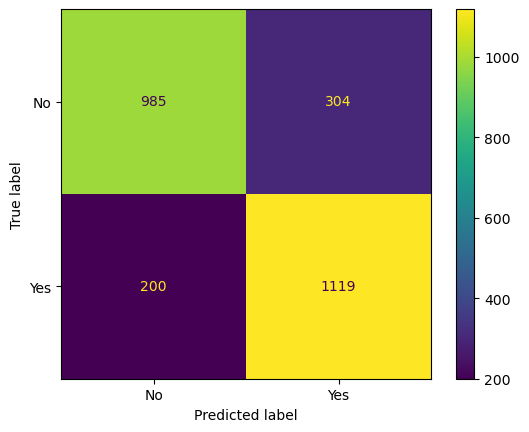

In [28]:
grid_prediction = grid.predict(X_validation)

grid_cm = ConfusionMatrixDisplay(confusion_matrix(y_validation, grid_prediction), display_labels=['No', 'Yes']).plot()
grid_cm
plt.show()

### Final Model

In [23]:
cat_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder())
    ])

num_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', Normalizer())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', cat_pipe, cat_feat.columns),
        ('scaler', num_pipe, num_feat.columns)
    ])

clf = Pipeline(
    steps=[
       ('preprocessor', preprocessor),
       ('selector', SelectKBest(score_func=chi2, k=best_k_value)),
       ('classifier', XGBClassifier())
    ])

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__max_depth': [4, 6, 8],
    'classifier__subsample': [0.5, 0.7, 0.9]
}

final_model = GridSearchCV(clf, param_grid, cv=5)

final_model.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'PassengerNumber',
       'GroupSize', 'CabinDeck', 'CabinSide', 'GroupNumberBuckets',
       'CabinNumberBuckets'],...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3],
                         'classifier__max_depth': [4, 6, 8],
                         'classifier__n_estimators': [50, 100],
                         'classifier__subsample': [0.5, 0.7, 0.9]})

In [27]:
joblib.dump(final_model, 'xgbclassifier_model_spaceship_titanic.pkl')

['xgbclassifier_model_spaceship_titanic.pkl']